# Power Outages
* **See the main project notebook for instructions to be sure you satisfy the rubric!**
* See Project 03 for information on the dataset.
* A few example prediction questions to pursue are listed below. However, don't limit yourself to them!
    * Predict the severity (number of customers, duration, or demand loss) of a major power outage.
    * Predict the cause of a major power outage.
    * Predict the number and/or severity of major power outages in the year 2020.
    * Predict the electricity consumption of an area.

Be careful to justify what information you would know at the "time of prediction" and train your model using only those features.

# Summary of Findings


### Introduction
In this project, I am attempting to predict the duration of the major power outage through a regression problem. Therefore, my target variable will be 'OUTAGE.DURATION' from the 'outage' dataset. The evaluation metric used is R^2.

### Baseline Model
For the baseline model, only three features are used. They are 'U.S._STATE', 'CAUSE.CATEGORY', and 'PC.REALGSP.REL'. The features 'U.S._STATE' and 'CAUSE.CATEGORY' are categorical features while 'PC.REALGSP.REL' is nominal. The R^2 of this model using the training sets was ~0.69 while the test sets gave a score of ~-0.18. I do not think this score is good. Even though the R^2 for the training set is relatively high, the model did not perform well on the test sets.

### Final Model
For the final model, new features were added. The features 'PC.REALGSP.REL' and 'PC.REALGSP.CHANGE' were standardized. The features 'OUTAGE.START.TIME' and 'MONTH' were split into 3 bins. Lastly, the features 'NERC.REGION', 'CLIMATE.CATEGORY', 'CLIMATE.REGION' were added as categorical features. The model type I chose was DecisionTreeRegressor and the parameters that performed the best was max_depth=30 and criterion='squared_error'. These parameters were chosen through a manual process.

### Fairness Evaluation
The results of the fairness evaluation concluded with the two groups 'east' and 'west' from CLIMATE.REGION being unfair. The pairity measure used for this test was R^2 since the model that was used is a regressor.

# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

### Baseline Model

In [28]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer


In [3]:
# read in the data
df = pd.read_excel('outage.xlsx', skiprows=[0,1,2,3,4])
# drop unnecessary columns
df = df.drop(columns=['variables', 'OBS']).drop(index=0)

# get relevant features
df_features = df[['U.S._STATE', 'CLIMATE.REGION', 'CAUSE.CATEGORY',  'POPULATION', 'PC.REALGSP.REL', 'PC.REALGSP.CHANGE', 'OUTAGE.DURATION', 'TOTAL.PRICE']]
df_features = df_features.dropna(subset=['CLIMATE.REGION', 'OUTAGE.DURATION'])
(df_features.head())

,U.S._STATE,CLIMATE.REGION,CAUSE.CATEGORY,POPULATION,PC.REALGSP.REL,PC.REALGSP.CHANGE,OUTAGE.DURATION,TOTAL.PRICE
1,Minnesota,East North Central,severe weather,5348119.0,1.077376,1.6,3060,9.28
2,Minnesota,East North Central,intentional attack,5457125.0,1.089792,1.9,1,9.28
3,Minnesota,East North Central,severe weather,5310903.0,1.066826,2.7,3000,8.15
4,Minnesota,East North Central,severe weather,5380443.0,1.071476,0.6,2550,9.19
5,Minnesota,East North Central,severe weather,5489594.0,1.092027,1.7,1740,10.43


For the baseline model, we will only use the features 'U.S._STATE', 'CAUSE.CATEGORY', and 'PC.REALGSP.REL'

In [4]:
# transform categorical features
X = df_features.drop('OUTAGE.DURATION', axis=1)
y = df_features['OUTAGE.DURATION']
# split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y)

# preprocessing
preproc = ColumnTransformer(transformers = [('one hot', OneHotEncoder(handle_unknown='ignore'), ['U.S._STATE', 'CAUSE.CATEGORY']), ('pass', 'passthrough', [ 'PC.REALGSP.REL'])], remainder='drop')

Below, we can see the R^2 scores for the training and testing data. This gives a baseline on how well the model does before feature engineering

In [5]:
pl = Pipeline([('preprocessor', preproc), ('lin reg', DecisionTreeRegressor())])
pl.fit(X_train, y_train)
print(pl.score(X_train, y_train))
print(pl.score(X_test, y_test))

0.7380848448415434
-0.7105398103321896


### Final Model

In [6]:
# read in the data
df = pd.read_excel('outage.xlsx', skiprows=[0,1,2,3,4])
# drop unnecessary columns
df = df.drop(columns=['variables', 'OBS']).drop(index=0)
# include 'CAUSE.CATEGORY.DETAIL'? 'OUTAGE.START.TIME',
df_features = df[['U.S._STATE', 'CLIMATE.REGION', 'CAUSE.CATEGORY',  'POPULATION', 'PC.REALGSP.REL', 'OUTAGE.DURATION', 'OUTAGE.START.TIME', 'MONTH', 'NERC.REGION', 'CLIMATE.CATEGORY', 'PC.REALGSP.CHANGE']]
df_features = df_features.dropna(subset=[ 'CLIMATE.REGION', 'OUTAGE.DURATION'])

df_features['OUTAGE.START.TIME'] = df_features['OUTAGE.START.TIME'].apply(lambda x: x.hour)
df_features

,U.S._STATE,CLIMATE.REGION,CAUSE.CATEGORY,POPULATION,PC.REALGSP.REL,OUTAGE.DURATION,OUTAGE.START.TIME,MONTH,NERC.REGION,CLIMATE.CATEGORY,PC.REALGSP.CHANGE
1,Minnesota,East North Central,severe weather,5348119.0,1.077376,3060,17,7.0,MRO,normal,1.6
2,Minnesota,East North Central,intentional attack,5457125.0,1.089792,1,18,5.0,MRO,normal,1.9
3,Minnesota,East North Central,severe weather,5310903.0,1.066826,3000,20,10.0,MRO,cold,2.7
4,Minnesota,East North Central,severe weather,5380443.0,1.071476,2550,4,6.0,MRO,normal,0.6
5,Minnesota,East North Central,severe weather,5489594.0,1.092027,1740,2,7.0,MRO,warm,1.7
...,...,...,...,...,...,...,...,...,...,...,...
1527,Idaho,Northwest,intentional attack,1680026.0,0.715673,0,0,3.0,WECC,warm,2.7
1529,Idaho,Northwest,system operability disruption,1680026.0,0.715673,220,15,7.0,WECC,normal,2.7
1530,North Dakota,West North Central,public appeal,685326.0,1.198083,720,8,12.0,MRO,cold,9.8
1532,South Dakota,West North Central,islanding,807067.0,0.968937,59,22,8.0,RFC,warm,0


For our model, we will standardize the 'PC.REALGSP.REL' and 'PC.REALGSP.CHANGE' columns, and split 'OUTAGE.START.TIME' and 'MONTH' into 3 bins. We also added the categorical features 'NERC.REGION', 'CLIMATE.CATEGORY', 'CLIMATE.REGION'

In [7]:
X = df_features.drop('OUTAGE.DURATION', axis=1)
y = df_features['OUTAGE.DURATION']

X_train, X_test, y_train, y_test = train_test_split(X, y)

preproc = ColumnTransformer(transformers = [('one hot', OneHotEncoder(handle_unknown='ignore'), ['U.S._STATE', 'CAUSE.CATEGORY', 'NERC.REGION', 'CLIMATE.CATEGORY', 'CLIMATE.REGION']),('std', StandardScaler(), ['PC.REALGSP.REL', 'PC.REALGSP.CHANGE']), ('kbins', KBinsDiscretizer(n_bins=3), ['OUTAGE.START.TIME', 'MONTH'])], remainder='drop')

In [20]:
pl = Pipeline([('preprocessor', preproc), ('dtr', DecisionTreeRegressor(max_depth=10))])
pl.fit(X_train, y_train)
pl.score(X_train, y_train)
# pl.score(X_t, y_train)

0.7967002031468747

In [21]:
pl.score(X_test, y_test)

0.2005310567748494

Manually look for the best max_depth hyperparameter

In [22]:
scores = []
for i in np.arange(1,30):
    pl = Pipeline([('preprocessor', preproc), ('dtr', DecisionTreeRegressor(max_depth=i, criterion='squared_error'))])
    pl.fit(X_train, y_train)
    scores.append(pl.score(X_train, y_train))

Try using gridsearch for the best hyperparameter

In [32]:
# hyperparameters
hyperparams = {'dtr__max_depth': [2, 3, 4, 5, 7, 10, 13, 15, 18, None],
                'dtr__min_samples_split': [2, 3, 5, 7, 10],
                'dtr__criterion': ["squared_error", "friedman_mse", "absolute_error", "poisson"]
            }

In [39]:
# searcher = GridSearchCV()
# DecisionTreeRegressor()
pl = Pipeline([('preprocessor', preproc), ('dtr', DecisionTreeRegressor())])
searcher = GridSearchCV(pl, param_grid=hyperparams, return_train_score=True, cv=5)
searcher.fit(X_train, y_train)
# searcher.score(X_train, y_train)
searcher.best_params_
# pl.score(X_t, y_train)

{'dtr__criterion': 'poisson',
 'dtr__max_depth': 2,
 'dtr__min_samples_split': 10}

It seems that a max depth of 30 is giving the best results

In [43]:
foo = Pipeline([('preprocessor', preproc), ('dtr', DecisionTreeRegressor(max_depth=10, criterion='squared_error', min_samples_split=2))])
foo.fit(X_train, y_train)
print(foo.score(X_train, y_train))
print(foo.score(X_test, y_test))

0.7967002031468747
0.189874818325784


In [27]:
fin_pl = Pipeline([('preprocessor', preproc), ('dtr', DecisionTreeRegressor(max_depth=10, criterion='squared_error'))])
fin_pl.fit(X_train, y_train)
print(fin_pl.score(X_train, y_train))
fin_pl.score(X_test, y_test)

0.7967002031468747


0.17987403712787542

In [500]:
y_pred = fin_pl.predict(X_test)

### Fairness Evaluation

Null Hypothesis: My model is fair; the R^2 for my two subsets are roughly the same

Alternative Hypothesis: My model is unfair; the R^2 is higher for Western Climate Regions than Eastern

In [501]:
from sklearn import metrics

In [502]:
df_parity = X_test.copy()[['CLIMATE.REGION']]
df_parity['predictions'] = y_pred
df_parity['OUTAGE.DURATION'] = y_test
df_parity = df_parity[df_parity['CLIMATE.REGION'] != 'Central']
df_parity['CLIMATE.REGION'] = df_parity['CLIMATE.REGION'].apply(lambda x: x.lower()).str.contains('east')
df_parity['CLIMATE.REGION'] = df_parity['CLIMATE.REGION'].apply(lambda x: 'east' if x is True else 'west')
df_parity = df_parity.reset_index(drop=True)
df_parity

,CLIMATE.REGION,predictions,OUTAGE.DURATION
0,west,70.000000,2
1,east,1395.000000,5160
2,east,2089.000000,4232
3,west,7200.000000,11880
4,east,206.714286,1
...,...,...,...
312,west,92.000000,161
313,west,355.000000,186
314,west,0.000000,0
315,east,10080.000000,76


In [503]:
df_parity.groupby('CLIMATE.REGION').mean()

,predictions
CLIMATE.REGION,
east,3317.429731
west,2225.436401


In [504]:
obs = df_parity.groupby('CLIMATE.REGION').apply(lambda x: metrics.r2_score(x['OUTAGE.DURATION'], x['predictions'])).diff().iloc[-1]
obs

0.3220608766280345

In [505]:
diffs = []
for i in range(100):
    s = df_parity.assign(is_east=df_parity['CLIMATE.REGION'].sample(frac=1.0, replace=False).reset_index(drop=True)).groupby('is_east').apply(lambda x: metrics.r2_score(x['OUTAGE.DURATION'], x['predictions'])).diff().iloc[-1]
    diffs.append(s)

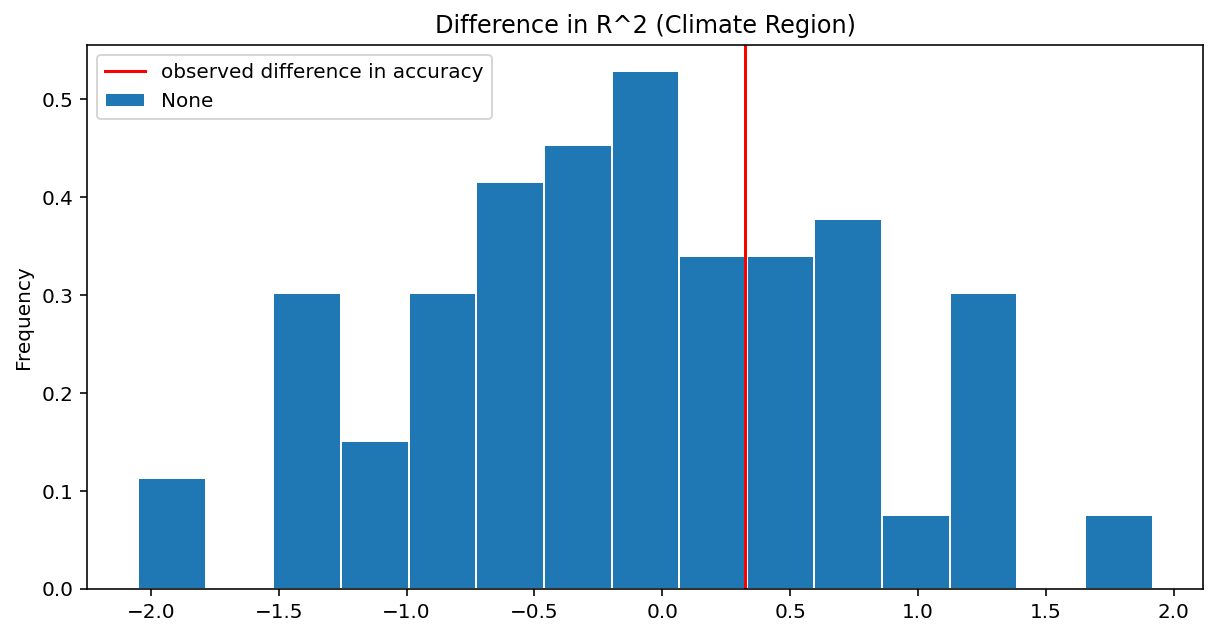

In [506]:
plt.figure(figsize=(10, 5))
pd.Series(diffs).plot(kind='hist', ec='w', density=True, bins=15, title='Difference in R^2 (Climate Region)')
plt.axvline(x=obs, color='red', label='observed difference in accuracy')
plt.legend(loc='upper left');

In [507]:
(obs <= diffs).mean()

0.31

It seems that the difference in R^2 across the two groups is significant, which is also shown by the pvalue of 0.31. So, the model does not achieve fairness.